In [1]:
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow import keras
from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2024-09-12 21:01:33.254156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 21:01:33.475051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 21:01:33.554433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 21:01:33.577201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 21:01:33.733596: I tensorflow/core/platform/cpu_feature_guar

In [2]:
image_dir = '/home/mint/repos/Satellite_Data/images'
mask_dir = '/home/mint/repos/Satellite_Data/labels'

image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

print("Image Paths:", image_paths)
print("Mask Paths:", mask_paths)

from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.15, random_state=42)

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.21, random_state=42)

batch_size = 32

Image Paths: ['/home/mint/repos/Satellite_Data/images/0.tif', '/home/mint/repos/Satellite_Data/images/1.tif', '/home/mint/repos/Satellite_Data/images/10.tif', '/home/mint/repos/Satellite_Data/images/100.tif', '/home/mint/repos/Satellite_Data/images/101.tif', '/home/mint/repos/Satellite_Data/images/102.tif', '/home/mint/repos/Satellite_Data/images/103.tif', '/home/mint/repos/Satellite_Data/images/104.tif', '/home/mint/repos/Satellite_Data/images/105.tif', '/home/mint/repos/Satellite_Data/images/106.tif', '/home/mint/repos/Satellite_Data/images/107.tif', '/home/mint/repos/Satellite_Data/images/108.tif', '/home/mint/repos/Satellite_Data/images/109.tif', '/home/mint/repos/Satellite_Data/images/11.tif', '/home/mint/repos/Satellite_Data/images/110.tif', '/home/mint/repos/Satellite_Data/images/111.tif', '/home/mint/repos/Satellite_Data/images/112.tif', '/home/mint/repos/Satellite_Data/images/113.tif', '/home/mint/repos/Satellite_Data/images/114.tif', '/home/mint/repos/Satellite_Data/images/11

In [3]:
import tifffile
def normalize_image(image):
    """
    Normalize image channel-wise to [0, 1] range.
    """
    normalized_image = np.zeros([128,128,12])
    for j in range(12):
        min_val = np.min(image[:,:,j])
        max_val = np.max(image[:,:,j])
        normalized_image[:,:,j] = (image[:,:,j] - min_val) / (max_val - min_val + 1e-6)

    return normalized_image

def load_image(image_path):
    image_path = tf.strings.as_string(image_path)
    image_path = image_path.numpy().decode('utf-8')
    image = tifffile.imread(image_path)
    #image = normalize_image(image)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    return image

def load_image_tf(image_path):
    return tf.py_function(load_image, [image_path], tf.float32)

def load_mask(mask_path):
    mask = Image.open(mask_path).convert('L')
    mask = np.expand_dims(mask, axis=-1).astype(np.float32)
    return mask

def load_image_and_mask(image_path, mask_path):
    image = load_image_tf(image_path)
    mask = load_mask(mask_path)
    return image, mask

def tf_parse(image_path, mask_path):
    image, mask = tf.numpy_function(load_image_and_mask, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([128, 128, 12])
    mask.set_shape([128, 128, 1])
    return image, mask

def augment(image, mask, seed):
    # Example augmentation functions
    image = tf.image.stateless_random_flip_left_right(image, seed=[seed, 0])
    mask = tf.image.stateless_random_flip_left_right(mask, seed=[seed, 0])
    
    image = tf.image.stateless_random_flip_up_down(image, seed=[seed, 1])
    mask = tf.image.stateless_random_flip_up_down(mask, seed=[seed, 1])
    
    image = tf.image.stateless_random_brightness(image, max_delta=0.1, seed=[seed, 2])
    
    image = tf.image.stateless_random_contrast(image, lower=0.8, upper=1.2, seed=[seed, 3])
    
    return image, mask

def create_dataset(image_paths, mask_paths, batch_size=batch_size, augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augmentation:
        dataset = dataset.map(lambda x, y: augment(x, y, 42), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_image_paths, train_mask_paths, batch_size, augmentation=True)
val_dataset = create_dataset(val_image_paths, val_mask_paths, batch_size, augmentation=False)
test_dataset = create_dataset(test_image_paths, test_mask_paths, batch_size, augmentation=False)

I0000 00:00:1726164097.847526     883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726164098.107215     883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726164098.107263     883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726164098.114726     883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726164098.114782     883 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
channel_names = ['Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA BAND', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability']

first_image_shape = None
consistent_shape = True

batch_images, batch_masks = next(iter(train_dataset.as_numpy_iterator()))
display = batch_images[np.random.randint(low = 32)]
display = normalize_image(display)
for i in range(len(batch_images)):
    if first_image_shape is None:
        first_image_shape = batch_images[i].shape
    else:
        if batch_images[i].shape != first_image_shape:
            print(f"Mismatch found: {batch_images[i].shape} != {first_image_shape}")
            consistent_shape = False
            break
print("Shape of batch_images:", batch_images.shape, "and len: ", len(batch_images))
print("Shape of batch_masks:", batch_masks.shape)
if consistent_shape:
    print(f"All images have the same shape: {first_image_shape}")
    input_shape = first_image_shape
else:
    print("Not all images have the same shape.")

Shape of batch_images: (32, 128, 128, 12) and len:  32
Shape of batch_masks: (32, 128, 128, 1)
All images have the same shape: (128, 128, 12)


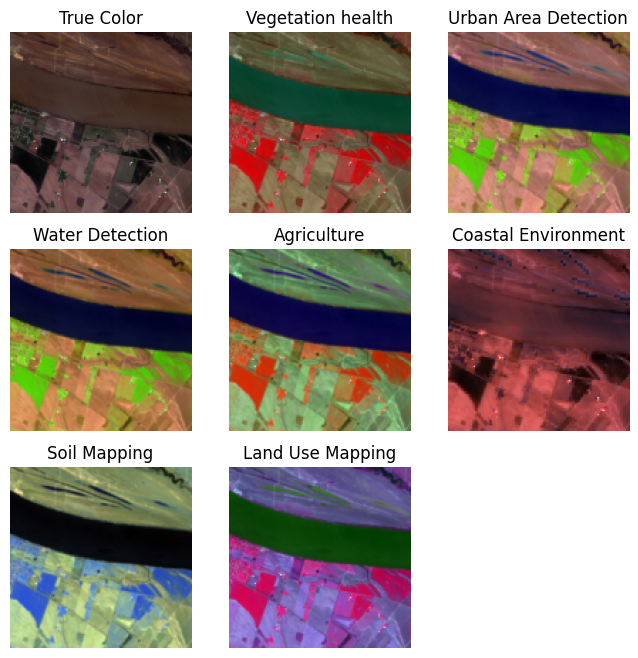

In [5]:
true_color = np.stack([display[:, :, channel_names.index('Red')],
                       display[:, :, channel_names.index('Green')],
                       display[:, :, channel_names.index('Blue')]], axis=-1)
false_color_vegetation = np.stack([display[:, :, channel_names.index('NIR')],
                                   display[:, :, channel_names.index('Red')],
                                   display[:, :, channel_names.index('Green')]], axis=-1)
urban_detection = np.stack([display[:, :, channel_names.index('SWIR1')],
                            display[:, :, channel_names.index('NIR')],
                            display[:, :, channel_names.index('Red')]], axis=-1)
water_detection = np.stack([display[:, :, channel_names.index('SWIR1')],
                            display[:, :, channel_names.index('NIR')],
                            display[:, :, channel_names.index('Green')]], axis=-1)
agriculture_composite = np.stack([display[:, :, channel_names.index('NIR')],
                           display[:, :, channel_names.index('SWIR2')],
                           display[:, :, channel_names.index('Red')]], axis=-1)
coastal_composite = np.stack([display[:, :, channel_names.index('Coastal aerosol')],
                              display[:, :, channel_names.index('Blue')],
                              display[:, :, channel_names.index('Green')]], axis=-1)
geology_composite = np.stack([display[:, :, channel_names.index('SWIR2')],
                              display[:, :, channel_names.index('SWIR1')],
                              display[:, :, channel_names.index('NIR')]], axis=-1)
landuse_composite = np.stack([display[:, :, channel_names.index('NIR')],
                              display[:, :, channel_names.index('Red')],
                              display[:, :, channel_names.index('SWIR1')]], axis=-1)

vis = {"True Color": true_color, "Vegetation health": false_color_vegetation, "Urban Area Detection": urban_detection, "Water Detection": water_detection,
       "Agriculture": agriculture_composite, "Coastal Environment": coastal_composite, "Soil Mapping": geology_composite, "Land Use Mapping": landuse_composite}

plt.figure(figsize=(len(vis), len(vis)))
index = 1
for name in vis:
    ax = plt.subplot(3, 3, index)
    plt.imshow(vis[name])
    plt.title(name)
    plt.axis("off")
    index += 1

In [6]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.optimizers import RMSprop, Nadam, SGD
from tensorflow.keras.models import Model

In [7]:
def conv_block(x, n_filters, dropout):
    # conv -> batchnorm -> relu -> dropout -> conv -> batchnorm -> relu
    # conv layers use_bias=False because batchnorm maintains its own bias
    x = Conv2D(n_filters, (3, 3), padding='same', use_bias = False, kernel_regularizer = keras.regularizers.l2(0.0005))(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout)(x)
    x = Conv2D(n_filters, (3, 3), padding='same', use_bias = False, kernel_regularizer = keras.regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def conv_block1(x, n_filters, dropout):
    # conv -> batchnorm -> relu -> dropout -> conv -> batchnorm -> relu
    x = Conv2D(n_filters, (3, 3), padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.0005))(x)
    x = Dropout(dropout)(x)
    x = Conv2D(n_filters, (3, 3), padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.0005))(x)
    return x

In [8]:
def encoder_block(x, n_filters, dropout):
    """conv block and pooling"""
    x = conv_block1(x, n_filters, dropout)
    p = Conv2D(n_filters, (2, 2), strides=2, padding='valid')(x)
    return x, p

In [9]:
def decoder_block(x, p, n_filters, dropout):
    """upsample, skip connection, and conv block"""
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, p])
    x = conv_block1(x, n_filters, dropout)
    return x

In [10]:
def multi_unet_model(input_shape):
    inputs = Input(input_shape)
    s = BatchNormalization()(inputs)
    dr = 0.15
    # Contraction path, encoder
    c2, p2 = encoder_block(s, n_filters=64, dropout=dr)
    c3, p3 = encoder_block(p2, n_filters=128, dropout=dr)
    c4, p4 = encoder_block(p3, n_filters=256, dropout=dr)
    c5, p5 = encoder_block(p4, n_filters=512, dropout=dr)

    # Bottleneck
    bridge = conv_block(p5, n_filters=1024, dropout=dr)
    
    # Expansive path, decoder
    u5 = decoder_block(bridge, c5, n_filters=512, dropout=dr)
    u4 = decoder_block(u5, c4, n_filters=256, dropout=dr)
    u3 = decoder_block(u4, c3, n_filters=128, dropout=dr)
    u2 = decoder_block(u3, c2, n_filters=64, dropout=dr)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u2)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

input_shape = first_image_shape
model = multi_unet_model(input_shape = input_shape)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.9,
    staircase=True
)
lr_schedule2 = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=3e-4,
    first_decay_steps=100,
    t_mul=2,
    m_mul=3,
    alpha=0.1
)

import segmentation_models as sm
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(optimizer = 'nadam', loss = total_loss, metrics = ["accuracy", "precision", "recall", sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
print(len(train_dataset), len(train_dataset.take(1)))
print(len(val_dataset), len(val_dataset.take(1)))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         48 │ cast[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     16,448 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     65,664 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ conv2d_5[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    262,400 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 32,436,721 (123.74 MB)

 Trainable params: 32,432,601 (123.72 MB)

 Non-trainable params: 4,120 (16.09 KB)

Segmentation Models: using `tf.keras` framework.
7 1
2 1


In [11]:
model_history = model.fit(train_dataset, validation_data = val_dataset, epochs = 100)

Epoch 1/100


I0000 00:00:1726164108.777131    1671 service.cc:146] XLA service 0x7fd98c003230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726164108.777167    1671 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-09-12 21:01:49.092279: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-12 21:01:49.944079: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-12 21:01:57.475855: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,128,128,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,128,128,64]{3,2,1,0}, f16[64,3,3,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_o

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3567 - f1-score: 0.3634 - iou_score: 0.2268 - loss: 3.0380 - precision: 0.2587 - recall: 0.6572

2024-09-12 21:02:51.375829: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 16 bytes spill stores, 16 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.3709 - f1-score: 0.3812 - iou_score: 0.2424 - loss: 2.9563 - precision: 0.2667 - recall: 0.7008 - val_accuracy: 0.2769 - val_f1-score: 0.4436 - val_iou_score: 0.2901 - val_loss: 2.0751 - val_precision: 0.2769 - val_recall: 1.0000
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.7069 - f1-score: 0.6642 - iou_score: 0.5059 - loss: 1.7437 - precision: 0.5148 - recall: 0.8595 - val_accuracy: 0.9055 - val_f1-score: 0.7989 - val_iou_score: 0.6651 - val_loss: 1.3777 - val_precision: 0.9755 - val_recall: 0.6758
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8617 - f1-score: 0.7529 - iou_score: 0.6087 - loss: 1.1000 - precision: 0.7701 - recall: 0.7416 - val_accuracy: 0.9106 - val_f1-score: 0.8122 - val_iou_score: 0.6838 - val_loss: 0.9576 - val_precision: 0.9704 - val_recall: 0.6984
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8739 - f1-score: 0.7739 - iou_score: 0.6344 - loss: 0.7423 - pre

In [12]:
loss, acc, prec, rec, iou, f1 = model.evaluate(test_dataset)
print(f"loss: {loss}\n acc: {acc}\n prec: {prec}\n rec: {rec}\n iou: {iou}\n f1: {f1}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9356 - f1-score: 0.8398 - iou_score: 0.7263 - loss: 0.2394 - precision: 0.8408 - recall: 0.8270  
loss: 0.2296004295349121
 acc: 0.9370077252388
 prec: 0.85674649477005
 rec: 0.8359264731407166
 iou: 0.7497533559799194
 f1: 0.8551331758499146


In [26]:
def plot_masks(image, ground_truth_mask, predicted_mask):
    
    ground_truth_mask = ground_truth_mask.squeeze()
    predicted_mask = predicted_mask.squeeze()

    rgb_image = image[:, :, 1:4]
    rgb_image = rgb_image[:, :, ::-1]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ground_truth_mask, cmap='gray')
    axes[0].set_title('Ground Truth Mask')
    axes[0].axis('off')
    
    axes[1].imshow(predicted_mask > 0.5, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    overlay = rgb_image.copy()
    overlay[predicted_mask > 0.5, :] = [1, 0, 0]  # Color overlay (e.g., red) for predicted mask
    axes[2].imshow(overlay)
    axes[2].set_title('Overlaid Mask')
    axes[2].axis('off')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


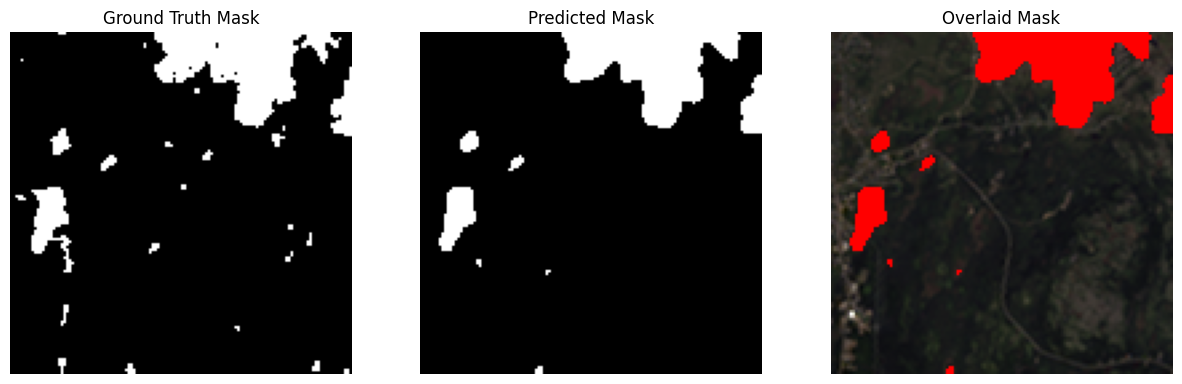

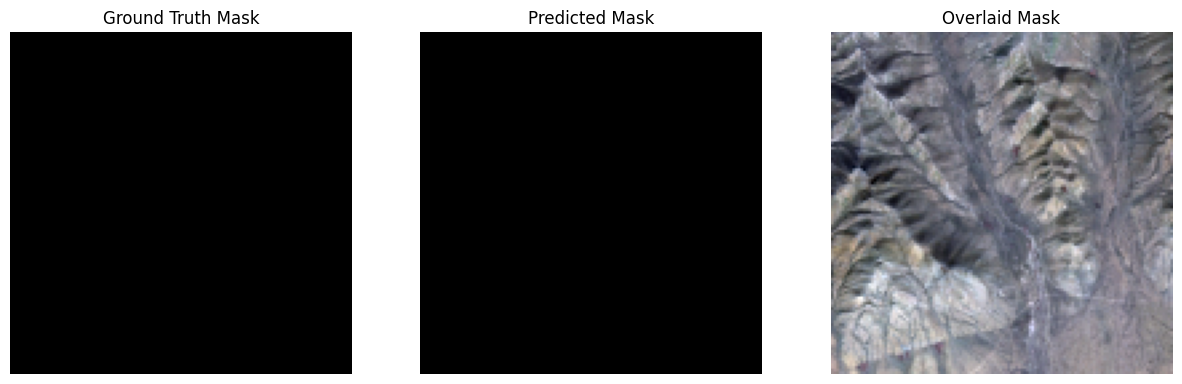

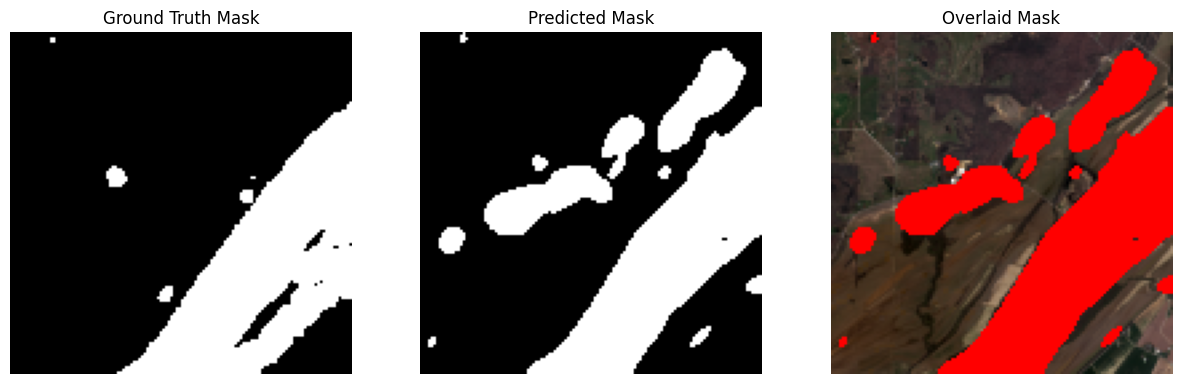

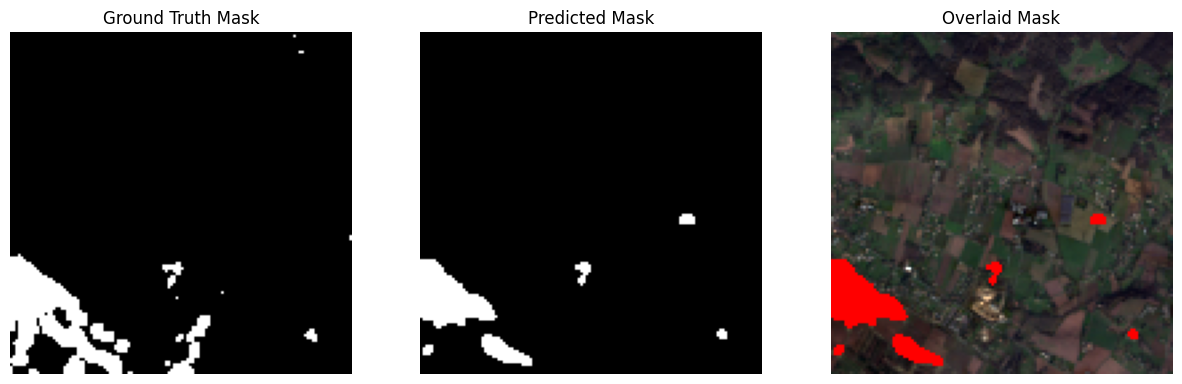

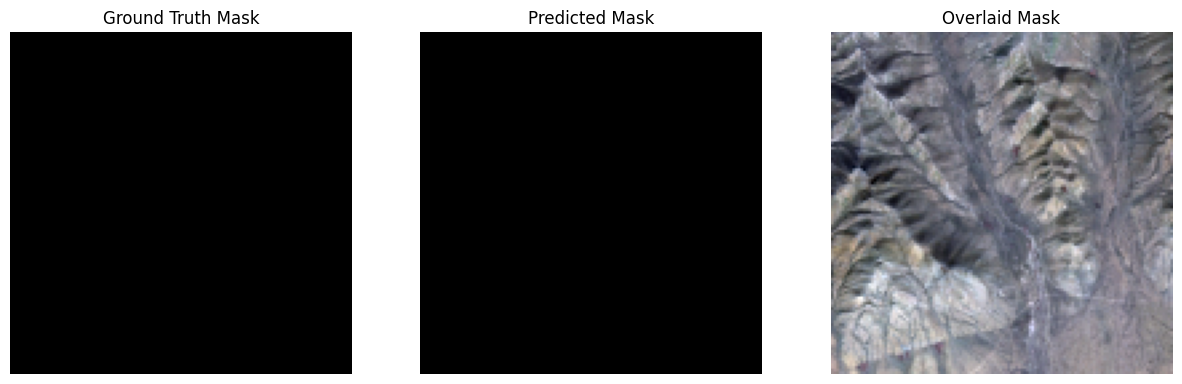

In [28]:
batch_images, batch_masks = next(iter(test_dataset.as_numpy_iterator()))
disp_preds = model.predict(batch_images)
for _ in range(5):
    ind = np.random.randint(low=0, high=batch_images.shape[0])
    display = normalize_image(batch_images[ind])
    disp_mask = batch_masks[ind]
    disp_pred = disp_preds[ind]
    
    plot_masks(display, disp_mask, disp_pred)

In [30]:
model.save("week_3.keras")